# TestSignal

Notebook to compare output of audio processing implemented in C in firmware with the expected output.

In [16]:
import math
import sys

sys.path.append("../")

import IPython
import matplotlib.pylab as plt
import numpy as np

from constants import SPEED_OF_SOUND

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [17]:
#out_dir = ""  # do not save
out_dir = '../firmware/audio_shield_firmware/Core/Inc/' # save

#buffer_length = 32 
buffer_length = 1024

simulated = True
#simulated = False

## 1.a Generate simulated signal

In [18]:
if simulated:
    from mic_array import get_uniform_array, ambiguity_test
    from signals import MonoSignal
    from algos_basics import get_mic_delays
    
    Fs = 32000
    start_idx = 100
    
    gt_elevation = None
    dimension = 2
    baseline = 0.1  # 15
    distance = 0.5  # distance of source
    gt_azimuth = 30 * np.pi / 180.0
    duration = 0.1  # seconds
    times = np.arange(0, duration, step=1 / Fs)
    added_noise_std = 1e-2  #
    frequency = 800

    source = distance * np.array([np.cos(gt_azimuth), np.sin(gt_azimuth)]).reshape((1, -1))
    mic_positions = get_uniform_array(mic_number=4, dimension=dimension, baseline=baseline)
    mic_ref = mic_positions[0]
    ambiguity_test(mic_positions, frequency)

    np.random.seed(1)

    delays = get_mic_delays(mic_positions, source)

    source_signal = MonoSignal(f=frequency)
    signals = np.array(
        [source_signal.evaluate(times + d, noise=0) for d in delays], dtype=np.float
    )

    if added_noise_std > 0:
        signals += np.random.normal(loc=0, scale=added_noise_std, size=signals.shape)

signal wavelength/2: 2.1e-01, minimum distance between mics 3.3e-02
signal wavelength is 12.4 times bigger than minimum mic distance. (Make sure it is more than 1)


## 1.b Generate real signal

In [19]:
if not simulated:
    from file_parser import read_recordings, parameters

    dir_name = "recordings_14_7_20"
    source = "200Hz"
    loudness = "high"
    gt_degrees = 0
    signals_props, signals_source, signals_all = read_recordings(dir_name, loudness, gt_degrees, source)
    
    Fs = parameters[dir_name]["Fs"]
    start_idx = parameters[dir_name]["time_index"]
    print(Fs)
    
    signals = signals_all
    print("read recordings")

## 2. Save signal

saved data as ../firmware/audio_shield_firmware/Core/Inc//simulated_data_1024.h


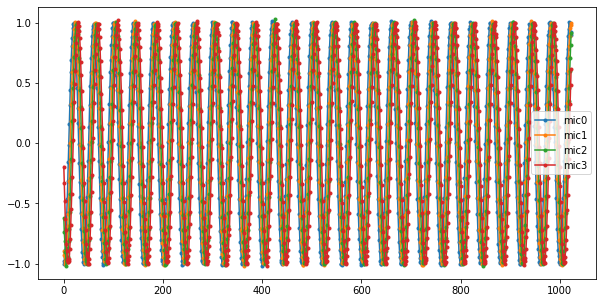

In [20]:
buffer = signals[:, start_idx : start_idx + buffer_length]
if simulated:
    name = f"simulated_data_{buffer_length}"
else:
    name = f"real_data_{buffer_length}"

if out_dir != "":
    fname = f"{out_dir}/{name}.h"
    with open(fname, "w") as f:
        for i, signal in enumerate(buffer):
            f.write(f"float32_t mic{i}[{buffer_length}] = " + r"{")
            [f.write(f"{s:.15f}, ",) for s in signal[:-1]]
            [f.write(f"{s:.15f}",) for s in signal[-1:]]
            # np.array_str(signal, precision=15, max_line_width=80))
            f.write(r"};" + " \n\n")
    print("saved data as", fname)

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
for i, signal in enumerate(buffer):
    ax.plot(signal, ".-", label=f"mic{i}", color=f"C{i}")
ax.legend()

## 3. Inspect signal

In [21]:
print(buffer[1])

[-0.89722329 -0.9304212  -0.98163242 ...  0.95674376  0.98714679
  0.99988849]


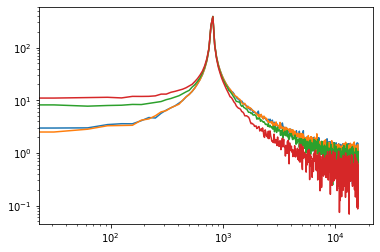

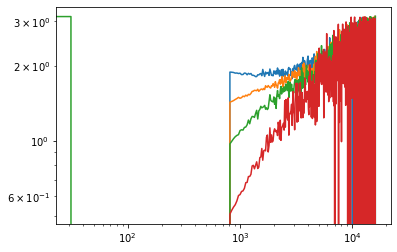

In [22]:
buffer_f = np.fft.rfft(buffer, buffer.shape[1], axis=1)
freq = np.fft.rfftfreq(n=buffer.shape[1], d=1/Fs)
plt.figure()
for i in range(buffer_f.shape[0]):
    plt.loglog(freq, np.abs(buffer_f[i]))
plt.figure()
for i in range(buffer_f.shape[0]):
    plt.loglog(freq, np.angle(buffer_f[i]))

## Frequency bin selection

[6, 7, 5, 4, 3, 14, 15, 16, 17, 25, 26, 27, 28, 35, 36, 37, 38, 45, 46, 47, 48, 50, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59]


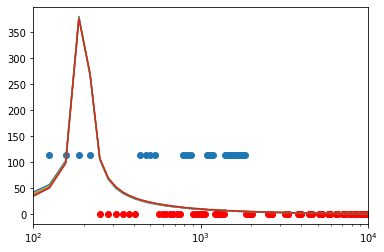

In [15]:
from bin_selection import select_frequencies, FFTSIZE_SENT

min_freq= 100
max_freq = 10000
filter_snr_enable = True #True # 
filter_props_enable = True #True #False

if filter_props_enable:
    thrust = 43000 
else:
    thrust = None
    
fig, ax = plt.subplots()
bins = select_frequencies(buffer_length, 
                          Fs, 
                          thrust=thrust, 
                          min_freq=min_freq, 
                          max_freq=max_freq, 
                          filter_snr=filter_snr_enable, 
                          buffer_f=buffer_f, 
                          ax=ax)
max_amp = np.max(np.abs(buffer_f[:, (freq<max_freq) & (freq>min_freq)]))
for i, signal in enumerate(buffer_f):
    ax.semilogx(freq, np.abs(signal), label = f"mic{i}")
ax.scatter(freq[bins], [0.3 * max_amp] * FFTSIZE_SENT)
ax.set_xlim(min_freq, max_freq)

print(bins)

## Not used anymore: matrix inversion stuff

In [ ]:
print(buffer.shape)
print(buffer_f.shape)
idx = 1
for real, imag in zip(buffer_f[idx, :].real, buffer_f[idx, :].imag):
    print(real, end=", ")
    print(imag)

In [ ]:
vectf = np.empty((buffer_f.shape[1], buffer_f.shape[0]*2))
for f in range(buffer_f.shape[1]):
    m = 0
    for mic in range(buffer_f.shape[0]):
        vectf[f, m] = buffer_f[mic, f].real
        vectf[f, m+1] = buffer_f[mic, f].imag
        m += 2
print('freq 0:', vectf[0])
print(vectf[:, 2:4].flatten())

print(buffer_f.shape)
for f in range(buffer_f.shape[1]):
    Rx = np.outer(buffer_f[:, f].conj(),  buffer_f[:, f])
 
    for i in range(Rx.shape[0]):
        for j in range(Rx.shape[1]):
            print(np.round(Rx[i, j].real, 5), end=",")
            print(np.round(Rx[i, j].imag, 5), end=",")
        print()
    print()
    break

In [ ]:
np.random.seed(1)
real = np.random.choice(9, size=9).reshape((3, 3))
imag = np.random.randint(9, size=9).reshape((3, 3))
compl = real + 1j*imag
print(compl)

In [ ]:
compl_inv = np.linalg.inv(compl)
print(compl_inv)

In [ ]:
vect_Xf = np.array([-5.253,-0.59, -4.108,-0.646, 6.035,-0.536, 7.132, -0.578])
vect_Xf_compl = vect_Xf[::2] + 1j*vect_Xf[1::2]

print(vect_Xf_compl)

lamda = 0.01
R = vect_Xf_compl.reshape((-1, 1)).dot(vect_Xf_compl.conj().reshape((1, -1)))
A = R.real + lamda * np.eye(R.shape[0])
B = R.imag + lamda * np.eye(R.shape[0])

In [ ]:
print(A)
print(np.linalg.inv(A))

In [ ]:
print(B)
print(np.linalg.matrix_rank(B))
print(np.linalg.inv(B))

In [ ]:
print(np.linalg.inv(A+1j*B))